Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
     |████████████████████████████████| 6.6 MB 64.5 MB/s 
     |████████████████████████████████| 596 kB 78.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=39bfb3912ffe070e6751372bc34964c4efaef1099484c67aede2819fd82c1a35
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['I-treatment', 'B-problem', 'B-treatment', 'I-test', 'I-problem', 'O', 'B-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-treatment', 'B-problem', 'B-treatment', 'I-test', 'I-problem', 'O', 'B-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-treatment', 'B-problem', 'B-treatment', 'I-test', 'I-problem', 'O', 'B-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

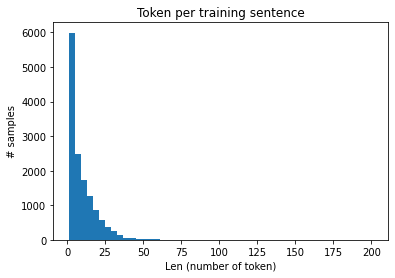

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

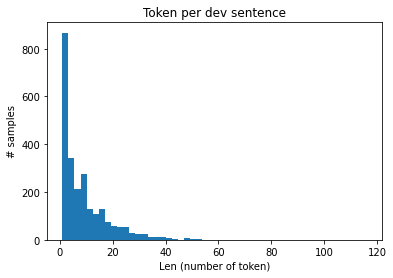

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

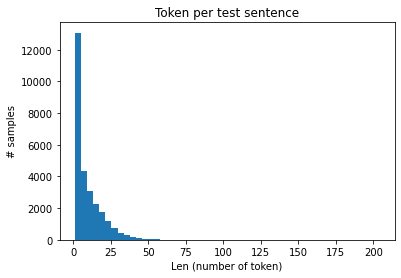

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

17077
curettage
2
I-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.25)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 10400
Points in y_train before removal: 10400


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

NameError: ignored

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.0 MB/s 
     |████████████████████████████████| 120 kB 94.6 MB/s 
     |████████████████████████████████| 6.6 MB 87.6 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=76dcabc76c41bee418958b627e04a2633c2a2c00244390ba8cd391b74317f99c
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[2158, 24943]
[5, 5]
[26193, 5489, 13041, 21644, 21084, 14996, 22881, 12397, 16282, 13698, 12383, 3573]
[1, 4, 4, 4, 4, 4, 5, 6, 3, 3, 3, 5]
[13337, 16888, 13823]
[5, 5, 5]
17077
2
B-treatment
lovenox
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3203089237213135
Training loss per 100 training steps: 0.40761561514717515
Training loss per 100 training steps: 0.3028717945649553
Training loss per 100 training steps: 0.2597341483019515
Training loss epoch: 0.2512640300163856
Training accuracy epoch: 0.91981688390127
Validating model...
Validation Loss: 0.13302011889490215
Validation Accuracy: 0.9574930571189033
Training epoch: 2
Training loss per 100 training steps: 0.10531175881624222
Training loss per 100 training steps: 0.09124035397452293
Training loss per 100 training steps: 0.09804092038107749
Training loss per 100 training steps: 0.09594611368726852
Training loss epoch: 0.0952254389742246
Training accuracy epoch: 0.9694504683638766
Validating model...
Validation Loss: 0.14844561370646026
Validation Accuracy: 0.9563273218678909
Training epoch: 3
Training loss per 100 training steps: 0.047116708010435104
Training loss per 100 training steps: 0.05026771921184984
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14249950173824025
Validation Accuracy: 0.9551748864525857
Validation duration: 3.6336561666666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

     problem       0.82      0.86      0.84     12546
        test       0.84      0.86      0.85      9012
   treatment       0.84      0.83      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.84      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1714978218078613
Training loss per 100 training steps: 0.3961095093648032
Training loss per 100 training steps: 0.28823489221322596
Training loss per 100 training steps: 0.2473734506959733
Training loss epoch: 0.24176963525322767
Training accuracy epoch: 0.9240612688864929
Validating model...
Validation Loss: 0.13831515982747078
Validation Accuracy: 0.9557598605684339
Training epoch: 2
Training loss per 100 training steps: 0.07780487090349197
Training loss per 100 training steps: 0.09563073584127545
Training loss per 100 training steps: 0.09526635203232516
Training loss per 100 training steps: 0.09245152334586726
Training loss epoch: 0.09236828974806345
Training accuracy epoch: 0.9704033667092682
Validating model...
Validation Loss: 0.14085623455028257
Validation Accuracy: 0.9555936249594793
Training epoch: 3
Training loss per 100 training steps: 0.08618216961622238
Training loss per 100 training steps: 0.05318350656105593
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1671942451837283
Validation Accuracy: 0.9549753318649836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.137380300000003 minutes
F1-score (test): 84.2%
              precision    recall  f1-score   support

     problem       0.85      0.85      0.85     12546
        test       0.82      0.86      0.84      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.008451223373413
Training loss per 100 training steps: 0.3925555350609345
Training loss per 100 training steps: 0.29391942195483106
Training loss per 100 training steps: 0.251383598671106
Training loss epoch: 0.243870289933223
Training accuracy epoch: 0.923264095590192
Validating model...
Validation Loss: 0.1447831860610417
Validation Accuracy: 0.9540533625447262
Training epoch: 2
Training loss per 100 training steps: 0.0721995010972023
Training loss per 100 training steps: 0.10331678847865303
Training loss per 100 training steps: 0.10314682940604972
Training loss per 100 training steps: 0.10050909681573658
Training loss epoch: 0.09962300357910303
Training accuracy epoch: 0.968374994403505
Validating model...
Validation Loss: 0.13142263654667835
Validation Accuracy: 0.9592927346595542
Training epoch: 3
Training loss per 100 training steps: 0.04425365850329399
Training loss per 100 training steps: 0.05735627788183565
Training loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14430508486973984
Validation Accuracy: 0.955517256717541
Validation duration: 3.1697266666666715 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.5%
              precision    recall  f1-score   support

     problem       0.84      0.87      0.85     12546
        test       0.85      0.88      0.87      9012
   treatment       0.83      0.87      0.85      9297

   micro avg       0.84      0.87      0.86     30855
   macro avg       0.84      0.87      0.86     30855
weighted avg       0.84      0.87      0.86     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9377415180206299
Training loss per 100 training steps: 0.3953828287154141
Training loss per 100 training steps: 0.2896611706460293
Training loss per 100 training steps: 0.2525927035441232
Training loss epoch: 0.2461658541399699
Training accuracy epoch: 0.9215872098971158
Validating model...
Validation Loss: 0.1477250370450995
Validation Accuracy: 0.9515839993045422
Training epoch: 2
Training loss per 100 training steps: 0.09828754514455795
Training loss per 100 training steps: 0.10702183940401762
Training loss per 100 training steps: 0.10407628531368514
Training loss per 100 training steps: 0.10102868669873655
Training loss epoch: 0.10095668718791925
Training accuracy epoch: 0.9668259079237845
Validating model...
Validation Loss: 0.13930271556238075
Validation Accuracy: 0.9578567813558272
Training epoch: 3
Training loss per 100 training steps: 0.04596981778740883
Training loss per 100 training steps: 0.052552913647550756
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15023117874753317
Validation Accuracy: 0.9554051493201067
Validation duration: 3.140964150000006 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.82      0.88      0.85      9012
   treatment       0.86      0.84      0.85      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0849807262420654
Training loss per 100 training steps: 0.3975902706532195
Training loss per 100 training steps: 0.29414225608777644
Training loss per 100 training steps: 0.25121300600691887
Training loss epoch: 0.24597891992101303
Training accuracy epoch: 0.9220359594863503
Validating model...
Validation Loss: 0.1376576946637073
Validation Accuracy: 0.9548596736425078
Training epoch: 2
Training loss per 100 training steps: 0.13924121856689453
Training loss per 100 training steps: 0.09218650286334872
Training loss per 100 training steps: 0.09471587805698316
Training loss per 100 training steps: 0.09772497464738712
Training loss epoch: 0.09840389366046741
Training accuracy epoch: 0.9683691725077513
Validating model...
Validation Loss: 0.13263989629393275
Validation Accuracy: 0.9589178253634156
Training epoch: 3
Training loss per 100 training steps: 0.05259533226490021
Training loss per 100 training steps: 0.05714804586484143
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14827833413275787
Validation Accuracy: 0.9541926383990422
Validation duration: 3.139198083333334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.84      0.85      0.84      9012
   treatment       0.83      0.86      0.85      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8840433359146118
Training loss per 100 training steps: 0.38999292822462495
Training loss per 100 training steps: 0.2895164326278131
Training loss per 100 training steps: 0.24965097084393928
Training loss epoch: 0.2423498176611387
Training accuracy epoch: 0.9235961657485446
Validating model...
Validation Loss: 0.14957445068889624
Validation Accuracy: 0.9528221213384709
Training epoch: 2
Training loss per 100 training steps: 0.06703794747591019
Training loss per 100 training steps: 0.1046767127100784
Training loss per 100 training steps: 0.09941111872000481
Training loss per 100 training steps: 0.09783270869069915
Training loss epoch: 0.09612333870851077
Training accuracy epoch: 0.9691190211901384
Validating model...
Validation Loss: 0.14981616385184326
Validation Accuracy: 0.9560497150144557
Training epoch: 3
Training loss per 100 training steps: 0.09054494649171829
Training loss per 100 training steps: 0.04668251520234833
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1649103025168491
Validation Accuracy: 0.9556777111789457
Validation duration: 3.13043438333331 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

     problem       0.83      0.87      0.85     12546
        test       0.81      0.86      0.84      9012
   treatment       0.85      0.84      0.85      9297

   micro avg       0.83      0.86      0.85     30855
   macro avg       0.83      0.86      0.85     30855
weighted avg       0.83      0.86      0.85     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.965802788734436
Training loss per 100 training steps: 0.4066520165836457
Training loss per 100 training steps: 0.3006540688116159
Training loss per 100 training steps: 0.2566983938415185
Training loss epoch: 0.24761659684089513
Training accuracy epoch: 0.92102741878044
Validating model...
Validation Loss: 0.13979145879675817
Validation Accuracy: 0.9550458491713547
Training epoch: 2
Training loss per 100 training steps: 0.13407091796398163
Training loss per 100 training steps: 0.0918639843342918
Training loss per 100 training steps: 0.0965130996348253
Training loss per 100 training steps: 0.09558796054959
Training loss epoch: 0.09598828614044648
Training accuracy epoch: 0.9695458764714197
Validating model...
Validation Loss: 0.1367836839870199
Validation Accuracy: 0.95645632153329
Training epoch: 3
Training loss per 100 training steps: 0.04423562437295914
Training loss per 100 training steps: 0.05414161362712926
Training loss per

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1493307672854927
Validation Accuracy: 0.9542362903200221
Validation duration: 3.1239853000000037 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.84      0.85      0.85     12546
        test       0.80      0.89      0.84      9012
   treatment       0.82      0.84      0.83      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1901283264160156
Training loss per 100 training steps: 0.4016031239292409
Training loss per 100 training steps: 0.29460552979761095
Training loss per 100 training steps: 0.25276825888905413
Training loss epoch: 0.2473306303987136
Training accuracy epoch: 0.9215851595528272
Validating model...
Validation Loss: 0.13780866839088401
Validation Accuracy: 0.9569523133025384
Training epoch: 2
Training loss per 100 training steps: 0.07523573935031891
Training loss per 100 training steps: 0.09492982702680153
Training loss per 100 training steps: 0.09269119482209433
Training loss per 100 training steps: 0.09728689391500134
Training loss epoch: 0.09688833209757622
Training accuracy epoch: 0.9694482900254441
Validating model...
Validation Loss: 0.14829488867869625
Validation Accuracy: 0.9539604475533855
Training epoch: 3
Training loss per 100 training steps: 0.04933161288499832
Training loss per 100 training steps: 0.05849022608213496
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15010059571661125
Validation Accuracy: 0.9527009889334663
Validation duration: 3.186955833333347 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

     problem       0.79      0.85      0.82     12546
        test       0.84      0.87      0.85      9012
   treatment       0.83      0.85      0.84      9297

   micro avg       0.82      0.85      0.83     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.85      0.83     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.27486515045166
Training loss per 100 training steps: 0.421496577192061
Training loss per 100 training steps: 0.30806759668894074
Training loss per 100 training steps: 0.2607883518171865
Training loss epoch: 0.2526194076010814
Training accuracy epoch: 0.9192598619460296
Validating model...
Validation Loss: 0.14102444531662123
Validation Accuracy: 0.9562310465334741
Training epoch: 2
Training loss per 100 training steps: 0.04746827855706215
Training loss per 100 training steps: 0.08841471269837406
Training loss per 100 training steps: 0.09838966520234424
Training loss per 100 training steps: 0.0976084413631909
Training loss epoch: 0.09750222608447075
Training accuracy epoch: 0.9682725811052451
Validating model...
Validation Loss: 0.13316817349427706
Validation Accuracy: 0.9573965475221343
Training epoch: 3
Training loss per 100 training steps: 0.0441327765583992
Training loss per 100 training steps: 0.05163347442164132
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14802121283288147
Validation Accuracy: 0.9537175436248998
Validation duration: 3.125277366666675 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

     problem       0.84      0.86      0.85     12546
        test       0.83      0.83      0.83      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 10400
Points in y_train after augmentation: 10400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3954944610595703
Training loss per 100 training steps: 0.39055789298940413
Training loss per 100 training steps: 0.2896832868790449
Training loss per 100 training steps: 0.25248253881386745
Training loss epoch: 0.24495492782730321
Training accuracy epoch: 0.9217799632212728
Validating model...
Validation Loss: 0.13812804464008901
Validation Accuracy: 0.9550541084797127
Training epoch: 2
Training loss per 100 training steps: 0.13426531851291656
Training loss per 100 training steps: 0.09379527337922908
Training loss per 100 training steps: 0.09533472225737216
Training loss per 100 training steps: 0.0962680158455952
Training loss epoch: 0.09551175453628485
Training accuracy epoch: 0.9687797916195008
Validating model...
Validation Loss: 0.1241398138030396
Validation Accuracy: 0.9615926641027186
Training epoch: 3
Training loss per 100 training steps: 0.13377878069877625
Training loss per 100 training steps: 0.054102768466835566
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14841764813819383
Validation Accuracy: 0.9560640483675207
Validation duration: 3.1898797166666553 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

     problem       0.83      0.84      0.84     12546
        test       0.84      0.87      0.85      9012
   treatment       0.83      0.88      0.85      9297

   micro avg       0.83      0.86      0.85     30855
   macro avg       0.83      0.86      0.85     30855
weighted avg       0.83      0.86      0.85     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9079480171203613
Training loss per 100 training steps: 0.3830591710192142
Training loss per 100 training steps: 0.28656814992427826
Training loss per 100 training steps: 0.24676575873084242
Training loss per 100 training steps: 0.22490343504452942
Training loss epoch: 0.22465390938103053
Training accuracy epoch: 0.9286786475964465
Validating model...
Validation Loss: 0.13577487636599447
Validation Accuracy: 0.9561244862208454
Training epoch: 2
Training loss per 100 training steps: 0.06522779166698456
Training loss per 100 training steps: 0.08742816582100817
Training loss per 100 training steps: 0.09776971781098132
Training loss per 100 training steps: 0.09495680391837988
Training loss per 100 training steps: 0.09476221801058164
Training loss epoch: 0.09508490639782216
Training accuracy epoch: 0.9689744213061773
Validating model...
Validation Loss: 0.14318906878689666
Validation Accuracy: 0.9558890650100874
Training epoch: 3
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14759612198988045
Validation Accuracy: 0.9525048728387645
Validation duration: 3.14567086666666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.82      0.82      0.82     12546
        test       0.82      0.88      0.85      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9052163362503052
Training loss per 100 training steps: 0.4040420615289471
Training loss per 100 training steps: 0.29779118520962955
Training loss per 100 training steps: 0.2548135355968907
Training loss per 100 training steps: 0.22827927710167933
Training loss epoch: 0.2265532085402006
Training accuracy epoch: 0.9287716417276388
Validating model...
Validation Loss: 0.14243329671973531
Validation Accuracy: 0.9529974834081216
Training epoch: 2
Training loss per 100 training steps: 0.0997057557106018
Training loss per 100 training steps: 0.09895185115608839
Stopping epoch...
Training loss epoch: 0.09895185115608839
Training accuracy epoch: 0.9595286695881858
Validating model...
Validation Loss: 0.16531837252633913
Validation Accuracy: 0.9495749259425178
Training epoch: 3
Training loss per 100 training steps: 0.10222838073968887
Training loss per 100 training steps: 0.08556896106035698
Training loss per 100 training steps: 0.0886746

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15113458208550043
Validation Accuracy: 0.9528268793260222
Validation duration: 3.1363946000000094 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.80      0.85      0.83     12546
        test       0.81      0.87      0.84      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.82      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1671574115753174
Training loss per 100 training steps: 0.408883936629437
Training loss per 100 training steps: 0.30022221566432744
Training loss per 100 training steps: 0.25947798110321907
Training loss per 100 training steps: 0.23181978641008202
Training loss epoch: 0.23074625816003988
Training accuracy epoch: 0.9258823088307215
Validating model...
Validation Loss: 0.15817842366439955
Validation Accuracy: 0.9471100743068527
Training epoch: 2
Training loss per 100 training steps: 0.09059377759695053
Training loss per 100 training steps: 0.08881211457866253
Training loss per 100 training steps: 0.09139774433008177
Training loss per 100 training steps: 0.09367475295099012
Training loss per 100 training steps: 0.09523575255261767
Training loss epoch: 0.09472917804965882
Training accuracy epoch: 0.9697841390732258
Validating model...
Validation Loss: 0.14340968763866982
Validation Accuracy: 0.9573063191577281
Training epoch: 3
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15648743219423555
Validation Accuracy: 0.9532313667627248
Validation duration: 3.151061600000018 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

     problem       0.80      0.88      0.84     12546
        test       0.85      0.87      0.86      9012
   treatment       0.84      0.86      0.85      9297

   micro avg       0.82      0.87      0.85     30855
   macro avg       0.83      0.87      0.85     30855
weighted avg       0.82      0.87      0.85     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.304074764251709
Training loss per 100 training steps: 0.40543632592895246
Training loss per 100 training steps: 0.29589638721883593
Training loss per 100 training steps: 0.2548419820683145
Training loss per 100 training steps: 0.23283944487980476
Training loss epoch: 0.23203304288245244
Training accuracy epoch: 0.9253927399132204
Validating model...
Validation Loss: 0.1370902353196175
Validation Accuracy: 0.955560849582808
Training epoch: 2
Training loss per 100 training steps: 0.059502843767404556
Training loss per 100 training steps: 0.08277539376833357
Training loss per 100 training steps: 0.08964794318641152
Training loss per 100 training steps: 0.08890316307705601
Training loss per 100 training steps: 0.09123088140505137
Training loss epoch: 0.09100815391794982
Training accuracy epoch: 0.9705766039338151
Validating model...
Validation Loss: 0.1386957209823387
Validation Accuracy: 0.9566455113405731
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1471321788461258
Validation Accuracy: 0.9527109599903879
Validation duration: 3.127350583333343 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.83     12546
        test       0.83      0.80      0.81      9012
   treatment       0.78      0.86      0.82      9297

   micro avg       0.80      0.85      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.85      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9637168645858765
Training loss per 100 training steps: 0.3988451599927232
Training loss per 100 training steps: 0.29646182801593
Training loss per 100 training steps: 0.2547167260632959
Training loss per 100 training steps: 0.23094264696586755
Training loss epoch: 0.22972386502443426
Training accuracy epoch: 0.9275369199616921
Validating model...
Validation Loss: 0.1511083743111654
Validation Accuracy: 0.9510710302102218
Training epoch: 2
Training loss per 100 training steps: 0.21258343756198883
Training loss per 100 training steps: 0.09227109471760174
Training loss per 100 training steps: 0.09196548470161596
Training loss per 100 training steps: 0.092002464869861
Training loss per 100 training steps: 0.09440225761086492
Training loss epoch: 0.09459754216647193
Training accuracy epoch: 0.9701591603034337
Validating model...
Validation Loss: 0.1403691065437221
Validation Accuracy: 0.9585995587475052
Training epoch: 3
Training los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15505366722182198
Validation Accuracy: 0.95269651526564
Validation duration: 3.119267583333385 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

     problem       0.80      0.88      0.84     12546
        test       0.79      0.88      0.83      9012
   treatment       0.83      0.85      0.84      9297

   micro avg       0.81      0.87      0.84     30855
   macro avg       0.81      0.87      0.84     30855
weighted avg       0.81      0.87      0.84     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0624327659606934
Training loss per 100 training steps: 0.41572485023205824
Training loss per 100 training steps: 0.30686889681501767
Training loss per 100 training steps: 0.25869133214518875
Training loss per 100 training steps: 0.2333008951305451
Training loss epoch: 0.23235414748329494
Training accuracy epoch: 0.9263610494529404
Validating model...
Validation Loss: 0.13593949055807156
Validation Accuracy: 0.9578780880528217
Training epoch: 2
Training loss per 100 training steps: 0.08302242308855057
Training loss per 100 training steps: 0.08909630812335723
Training loss per 100 training steps: 0.09342399801113713
Training loss per 100 training steps: 0.09237163955735606
Training loss per 100 training steps: 0.09254970358094744
Training loss epoch: 0.09264207361563491
Training accuracy epoch: 0.9706622968335298
Validating model...
Validation Loss: 0.141524676596383
Validation Accuracy: 0.9555887194480587
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14194076778625864
Validation Accuracy: 0.9551154332368786
Validation duration: 3.1228185166666664 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

     problem       0.82      0.84      0.83     12546
        test       0.85      0.87      0.86      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.84      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9577995538711548
Training loss per 100 training steps: 0.45133859863375675
Training loss per 100 training steps: 0.3265960137197627
Training loss per 100 training steps: 0.2772462699450924
Training loss per 100 training steps: 0.2494472423359343
Training loss epoch: 0.24749816786635126
Training accuracy epoch: 0.9224228524294745
Validating model...
Validation Loss: 0.16170967554117177
Validation Accuracy: 0.9461719483744532
Training epoch: 2
Training loss per 100 training steps: 0.08476591855287552
Training loss per 100 training steps: 0.09429103414537293
Training loss per 100 training steps: 0.09568410290785097
Training loss per 100 training steps: 0.09574123031995027
Training loss per 100 training steps: 0.09520954451177668
Training loss epoch: 0.09492338678161144
Training accuracy epoch: 0.9696000505601619
Validating model...
Validation Loss: 0.13586679833953258
Validation Accuracy: 0.9590137199150804
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15261693106084648
Validation Accuracy: 0.9534342575951539
Validation duration: 3.1242668166666894 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.83      0.85      0.84      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0352087020874023
Training loss per 100 training steps: 0.43208680914180114
Training loss per 100 training steps: 0.31471863718916526
Training loss per 100 training steps: 0.26751180683754605
Training loss per 100 training steps: 0.24240712941324621
Training loss epoch: 0.24134437766392927
Training accuracy epoch: 0.9239395057007064
Validating model...
Validation Loss: 0.1591645750616278
Validation Accuracy: 0.9505611976402223
Training epoch: 2
Training loss per 100 training steps: 0.19075839221477509
Training loss per 100 training steps: 0.09917204452697004
Training loss per 100 training steps: 0.0986815887452358
Training loss per 100 training steps: 0.10195151985038159
Training loss per 100 training steps: 0.09826692418564585
Training loss epoch: 0.09811514023810405
Training accuracy epoch: 0.968232333725011
Validating model...
Validation Loss: 0.14060703834349458
Validation Accuracy: 0.9585298404191623
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15902676817064207
Validation Accuracy: 0.9533857164586187
Validation duration: 3.1367103500000666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.83     12546
        test       0.85      0.88      0.86      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0366172790527344
Training loss per 100 training steps: 0.3925679239011047
Training loss per 100 training steps: 0.2939701478427915
Training loss per 100 training steps: 0.25198636065388835
Training loss per 100 training steps: 0.22817104379936792
Training loss epoch: 0.22726908122493683
Training accuracy epoch: 0.9285562649100142
Validating model...
Validation Loss: 0.16152678501441495
Validation Accuracy: 0.9495005762689044
Training epoch: 2
Training loss per 100 training steps: 0.09670598059892654
Training loss per 100 training steps: 0.09622288987704433
Stopping epoch...
Training loss epoch: 0.09622288987704433
Training accuracy epoch: 0.9598750623386034
Validating model...
Validation Loss: 0.15588857746356494
Validation Accuracy: 0.953825748655458
Training epoch: 3
Training loss per 100 training steps: 0.08825293183326721
Training loss per 100 training steps: 0.08151792823383124
Training loss per 100 training steps: 0.079556

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15455147468687588
Validation Accuracy: 0.9517999829485829
Validation duration: 3.1325940499998977 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

     problem       0.80      0.85      0.82     12546
        test       0.80      0.89      0.85      9012
   treatment       0.83      0.85      0.84      9297

   micro avg       0.81      0.86      0.84     30855
   macro avg       0.81      0.86      0.84     30855
weighted avg       0.81      0.86      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 13000
Points in y_train after augmentation: 13000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0217506885528564
Training loss per 100 training steps: 0.4123083607542633
Training loss per 100 training steps: 0.30152111170600304
Training loss per 100 training steps: 0.25984405102424846
Training loss per 100 training steps: 0.23390494094710992
Training loss epoch: 0.2320968999529683
Training accuracy epoch: 0.9272426558538038
Validating model...
Validation Loss: 0.15312627872282808
Validation Accuracy: 0.9524219022713837
Training epoch: 2
Training loss per 100 training steps: 0.15340463817119598
Training loss per 100 training steps: 0.09635453084760373
Training loss per 100 training steps: 0.093871104456855
Training loss per 100 training steps: 0.09008689338582694
Training loss per 100 training steps: 0.09184082199417594
Training loss epoch: 0.09153417255775202
Training accuracy epoch: 0.9698345860227497
Validating model...
Validation Loss: 0.14793073675026755
Validation Accuracy: 0.9550676022344234
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16585646845784072
Validation Accuracy: 0.9492249499360226
Validation duration: 3.1228189333332312 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.78      0.87      0.82     12546
        test       0.86      0.74      0.80      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.82      0.83      0.82     30855
   macro avg       0.82      0.82      0.82     30855
weighted avg       0.82      0.83      0.82     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.049926996231079
Training loss per 100 training steps: 0.4008155125792664
Training loss per 100 training steps: 0.2995872188971114
Training loss per 100 training steps: 0.2549110775893907
Training loss per 100 training steps: 0.23005867080572537
Training loss epoch: 0.21551942052777673
Training accuracy epoch: 0.9322888497642698
Validating model...
Validation Loss: 0.15181760049679063
Validation Accuracy: 0.9516726260647504
Training epoch: 2
Training loss per 100 training steps: 0.13016054034233093
Training loss per 100 training steps: 0.09024752931909101
Training loss per 100 training steps: 0.08614405671329196
Training loss per 100 training steps: 0.08753388442804548
Training loss per 100 training steps: 0.0869681116755578
Training loss epoch: 0.08673183815210264
Training accuracy epoch: 0.9729559218840983
Validating model...
Validation Loss: 0.15220638567751105
Validation Accuracy: 0.9554430848869345
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16280042236300046
Validation Accuracy: 0.9497101331158424
Validation duration: 3.113467883333336 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.77      0.86      0.81     12546
        test       0.84      0.84      0.84      9012
   treatment       0.86      0.79      0.82      9297

   micro avg       0.81      0.83      0.82     30855
   macro avg       0.82      0.83      0.82     30855
weighted avg       0.81      0.83      0.82     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.080531358718872
Training loss per 100 training steps: 0.40443910481316026
Training loss per 100 training steps: 0.3055088676475174
Training loss per 100 training steps: 0.2597160039352024
Training loss per 100 training steps: 0.23500635526944277
Training loss epoch: 0.21695237318969895
Training accuracy epoch: 0.932325577404797
Validating model...
Validation Loss: 0.1469018017123272
Validation Accuracy: 0.952511591891586
Training epoch: 2
Training loss per 100 training steps: 0.10696505755186081
Training loss per 100 training steps: 0.08820847391455185
Training loss per 100 training steps: 0.0878231510941625
Training loss per 100 training steps: 0.08697717878627173
Training loss per 100 training steps: 0.08646663408285178
Training loss epoch: 0.08590559635528928
Training accuracy epoch: 0.9723730542532883
Validating model...
Validation Loss: 0.14594112697069522
Validation Accuracy: 0.9561929733613436
Training epoch: 3
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16091832176230295
Validation Accuracy: 0.952436403121124
Validation duration: 3.1229920999999496 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.82      0.87      0.84      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8436211347579956
Training loss per 100 training steps: 0.3938376053725139
Training loss per 100 training steps: 0.2915358378816007
Training loss per 100 training steps: 0.25425927868218123
Training loss per 100 training steps: 0.22701489605343997
Training loss epoch: 0.2100673148820757
Training accuracy epoch: 0.9332199446967911
Validating model...
Validation Loss: 0.14178921652401422
Validation Accuracy: 0.9549232315859109
Training epoch: 2
Training loss per 100 training steps: 0.04371100664138794
Training loss per 100 training steps: 0.08412124251596409
Training loss per 100 training steps: 0.08098640354971091
Training loss per 100 training steps: 0.07945040056475769
Training loss per 100 training steps: 0.0808414538202812
Training loss epoch: 0.08096916576251999
Training accuracy epoch: 0.974212485243007
Validating model...
Validation Loss: 0.1467319205403328
Validation Accuracy: 0.955960517190366
Training epoch: 3
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15891643616163897
Validation Accuracy: 0.9505639341278008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1109949666667185 minutes
F1-score (test): 82.6%
              precision    recall  f1-score   support

     problem       0.80      0.83      0.82     12546
        test       0.83      0.83      0.83      9012
   treatment       0.82      0.85      0.83      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9586379528045654
Training loss per 100 training steps: 0.41036952050900694
Training loss per 100 training steps: 0.3021438064711604
Training loss per 100 training steps: 0.2605755602278781
Training loss per 100 training steps: 0.23325711956939793
Training loss epoch: 0.215769875359523
Training accuracy epoch: 0.9318527099963909
Validating model...
Validation Loss: 0.1438089506579684
Validation Accuracy: 0.9510498462464714
Training epoch: 2
Training loss per 100 training steps: 0.08245614171028137
Training loss per 100 training steps: 0.08288755652374856
Stopping epoch...
Training loss epoch: 0.08288755652374856
Training accuracy epoch: 0.9643554287256455
Validating model...
Validation Loss: 0.15533941930958203
Validation Accuracy: 0.9546899792207767
Training epoch: 3
Training loss per 100 training steps: 0.041710708290338516
Training loss per 100 training steps: 0.07348643938577411
Training loss per 100 training steps: 0.0729669

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15549749587188233
Validation Accuracy: 0.949243246209519
Validation duration: 3.132033566666723 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.3%
              precision    recall  f1-score   support

     problem       0.79      0.83      0.81     12546
        test       0.82      0.86      0.84      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.81      0.84      0.82     30855
   macro avg       0.81      0.84      0.83     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9416898488998413
Training loss per 100 training steps: 0.43124817156850703
Training loss per 100 training steps: 0.3156235427294501
Training loss per 100 training steps: 0.2696727667239021
Training loss per 100 training steps: 0.2409118677110892
Training loss epoch: 0.22077379924947488
Training accuracy epoch: 0.930180634744164
Validating model...
Validation Loss: 0.14715387822165119
Validation Accuracy: 0.9518128305659802
Training epoch: 2
Training loss per 100 training steps: 0.15125121176242828
Training loss per 100 training steps: 0.08878854642815814
Training loss per 100 training steps: 0.08757660435558996
Training loss per 100 training steps: 0.08906116782133762
Training loss per 100 training steps: 0.08935996294114507
Training loss epoch: 0.0905695577022299
Training accuracy epoch: 0.9708993788639595
Validating model...
Validation Loss: 0.14595163678871348
Validation Accuracy: 0.9561502429927136
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1625679134848286
Validation Accuracy: 0.9522570710104802
Validation duration: 3.151947600000009 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.82      0.85      0.84     12546
        test       0.77      0.89      0.82      9012
   treatment       0.79      0.88      0.83      9297

   micro avg       0.80      0.87      0.83     30855
   macro avg       0.79      0.87      0.83     30855
weighted avg       0.80      0.87      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.867986798286438
Training loss per 100 training steps: 0.39883497379498906
Training loss per 100 training steps: 0.2980709731652962
Training loss per 100 training steps: 0.25739160982081266
Training loss per 100 training steps: 0.23160973086748782
Training loss epoch: 0.21748260023515123
Training accuracy epoch: 0.9296529118123411
Validating model...
Validation Loss: 0.13234497669648815
Validation Accuracy: 0.9577034163998227
Training epoch: 2
Training loss per 100 training steps: 0.06743905693292618
Training loss per 100 training steps: 0.08266143142107395
Training loss per 100 training steps: 0.08141459557528964
Training loss per 100 training steps: 0.08344717843897417
Training loss per 100 training steps: 0.08163584301485088
Training loss epoch: 0.08142414678376718
Training accuracy epoch: 0.9741698842122575
Validating model...
Validation Loss: 0.14375995936525332
Validation Accuracy: 0.9553826358651868
Training epoch: 3
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1461165054147218
Validation Accuracy: 0.9534222635285815
Validation duration: 3.12287943333334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.82     12546
        test       0.83      0.87      0.85      9012
   treatment       0.83      0.84      0.83      9297

   micro avg       0.82      0.85      0.83     30855
   macro avg       0.82      0.85      0.84     30855
weighted avg       0.82      0.85      0.83     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3694281578063965
Training loss per 100 training steps: 0.4129649240634229
Training loss per 100 training steps: 0.3143574187708138
Training loss per 100 training steps: 0.26785955496404656
Training loss per 100 training steps: 0.24015495915922738
Training loss epoch: 0.221766414975778
Training accuracy epoch: 0.929985892059251
Validating model...
Validation Loss: 0.14194080644807258
Validation Accuracy: 0.9533589259558384
Training epoch: 2
Training loss per 100 training steps: 0.07015719264745712
Training loss per 100 training steps: 0.08211166390429923
Training loss per 100 training steps: 0.07966618879295106
Training loss per 100 training steps: 0.08263834735898432
Training loss per 100 training steps: 0.08631718493974826
Training loss epoch: 0.08585567877186104
Training accuracy epoch: 0.9724055302735253
Validating model...
Validation Loss: 0.15224950755764913
Validation Accuracy: 0.9559415823158259
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15608221627944321
Validation Accuracy: 0.9515665871247031
Validation duration: 3.1316356833332977 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.83      0.83      0.83     12546
        test       0.84      0.85      0.84      9012
   treatment       0.77      0.88      0.82      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.426107168197632
Training loss per 100 training steps: 0.42973511525900054
Training loss per 100 training steps: 0.31564272304450103
Training loss per 100 training steps: 0.2683028782597214
Training loss per 100 training steps: 0.23871546971641872
Training loss epoch: 0.22095399772839958
Training accuracy epoch: 0.9310865893155408
Validating model...
Validation Loss: 0.14566580752854225
Validation Accuracy: 0.9542411858818091
Training epoch: 2
Training loss per 100 training steps: 0.06781281530857086
Training loss per 100 training steps: 0.08991003017134891
Training loss per 100 training steps: 0.08762104053569225
Training loss per 100 training steps: 0.08506197747511424
Training loss per 100 training steps: 0.08760804894549815
Training loss epoch: 0.0876192863721431
Training accuracy epoch: 0.971943919597171
Validating model...
Validation Loss: 0.14730818296310963
Validation Accuracy: 0.9552729711877073
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15404227191875516
Validation Accuracy: 0.952826677345887
Validation duration: 3.1171591999999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

     problem       0.83      0.82      0.82     12546
        test       0.85      0.86      0.86      9012
   treatment       0.82      0.84      0.83      9297

   micro avg       0.83      0.84      0.84     30855
   macro avg       0.83      0.84      0.84     30855
weighted avg       0.83      0.84      0.84     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7530591487884521
Training loss per 100 training steps: 0.37903908426218696
Training loss per 100 training steps: 0.2891095745659883
Training loss per 100 training steps: 0.2531625112005048
Training loss per 100 training steps: 0.22803580954187827
Training loss epoch: 0.2134853454619707
Training accuracy epoch: 0.9327573926211562
Validating model...
Validation Loss: 0.15851619892886706
Validation Accuracy: 0.9470590136598299
Training epoch: 2
Training loss per 100 training steps: 0.10550597310066223
Training loss per 100 training steps: 0.0927765471030875
Training loss per 100 training steps: 0.09053145010784194
Training loss per 100 training steps: 0.0874747686471753
Training loss per 100 training steps: 0.08783256721466855
Training loss epoch: 0.08715561659029517
Training accuracy epoch: 0.9720513768202862
Validating model...
Validation Loss: 0.14597207387643202
Validation Accuracy: 0.9556001583953262
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16873575651078243
Validation Accuracy: 0.9521950070534423
Validation duration: 3.129662316666751 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.83      0.86      0.84      9012
   treatment       0.85      0.82      0.84      9297

   micro avg       0.82      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.82      0.85      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 15600
Points in y_train after augmentation: 15600
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2021994590759277
Training loss per 100 training steps: 0.41707961873547866
Training loss per 100 training steps: 0.3130807931076235
Training loss per 100 training steps: 0.26955737537422847
Training loss per 100 training steps: 0.24066468357965537
Training loss epoch: 0.2239817662821075
Training accuracy epoch: 0.9298772805006441
Validating model...
Validation Loss: 0.14273801010537457
Validation Accuracy: 0.9529713129847341
Training epoch: 2
Training loss per 100 training steps: 0.1456833928823471
Training loss per 100 training steps: 0.08589888159370068
Training loss per 100 training steps: 0.08766797447660521
Training loss per 100 training steps: 0.0882344621069655
Training loss per 100 training steps: 0.08750406742569737
Training loss epoch: 0.08655796477525327
Training accuracy epoch: 0.9729937043769865
Validating model...
Validation Loss: 0.15838067250495608
Validation Accuracy: 0.9552778710488199
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15286674391461053
Validation Accuracy: 0.9514821133455547
Validation duration: 3.1383739499999743 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

     problem       0.80      0.84      0.82     12546
        test       0.84      0.82      0.83      9012
   treatment       0.84      0.83      0.83      9297

   micro avg       0.82      0.83      0.83     30855
   macro avg       0.82      0.83      0.83     30855
weighted avg       0.82      0.83      0.83     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.287151336669922
Training loss per 100 training steps: 0.430377853683906
Training loss per 100 training steps: 0.31723537852070227
Training loss per 100 training steps: 0.2692449155613236
Training loss per 100 training steps: 0.24038142418289124
Training loss per 100 training steps: 0.22067435174630193
Training loss epoch: 0.21024370464203332
Training accuracy epoch: 0.9333362515861734
Validating model...
Validation Loss: 0.13635875732190422
Validation Accuracy: 0.9555969041973891
Training epoch: 2
Training loss per 100 training steps: 0.06050816923379898
Training loss per 100 training steps: 0.08199495617484692
Training loss per 100 training steps: 0.08475782207458915
Training loss per 100 training steps: 0.08002915433252175
Training loss per 100 training steps: 0.08130469003185964
Training loss per 100 training steps: 0.08095291874254357
Training loss epoch: 0.08103985629275258
Training accuracy epoch: 0.9751069268494645
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14937761499486105
Validation Accuracy: 0.9510510641934936
Validation duration: 3.1284943666666853 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.8%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.82     12546
        test       0.83      0.85      0.84      9012
   treatment       0.78      0.87      0.83      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.80      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9498547315597534
Training loss per 100 training steps: 0.39764722008811365
Training loss per 100 training steps: 0.3049257053664668
Training loss per 100 training steps: 0.25747126922555935
Training loss per 100 training steps: 0.23254959381875254
Training loss per 100 training steps: 0.2136693448571864
Training loss epoch: 0.2036467397516767
Training accuracy epoch: 0.9353815672026308
Validating model...
Validation Loss: 0.16664367851305317
Validation Accuracy: 0.9480990810762582
Training epoch: 2
Training loss per 100 training steps: 0.12934444844722748
Training loss per 100 training steps: 0.08101038811820568
Training loss per 100 training steps: 0.07723060661268916
Training loss per 100 training steps: 0.08052397903946051
Training loss per 100 training steps: 0.08165550522942867
Training loss per 100 training steps: 0.07898432653427065
Training loss epoch: 0.07949835065791551
Training accuracy epoch: 0.9751001180412034
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17038403647085135
Validation Accuracy: 0.9521065054144621
Validation duration: 3.126015499999994 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.6%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.83     12546
        test       0.79      0.84      0.82      9012
   treatment       0.84      0.82      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.84      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.044574499130249
Training loss per 100 training steps: 0.39886827626735855
Training loss per 100 training steps: 0.29624117002706624
Training loss per 100 training steps: 0.2544516506558439
Training loss per 100 training steps: 0.22795622235633192
Training loss per 100 training steps: 0.20995550973716373
Training loss epoch: 0.20097473698466858
Training accuracy epoch: 0.9367525322344943
Validating model...
Validation Loss: 0.14792909509466065
Validation Accuracy: 0.9514822435093226
Training epoch: 2
Training loss per 100 training steps: 0.09636063873767853
Training loss per 100 training steps: 0.08146102218381544
Training loss per 100 training steps: 0.08202744665930965
Training loss per 100 training steps: 0.08036116759394886
Training loss per 100 training steps: 0.07966100322570364
Training loss per 100 training steps: 0.08017971002851834
Training loss epoch: 0.07988502488754728
Training accuracy epoch: 0.9747471121715824
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1658160614843601
Validation Accuracy: 0.9492613448566802
Validation duration: 3.126582033333398 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.3%
              precision    recall  f1-score   support

     problem       0.83      0.79      0.81     12546
        test       0.81      0.86      0.83      9012
   treatment       0.79      0.86      0.83      9297

   micro avg       0.81      0.83      0.82     30855
   macro avg       0.81      0.84      0.82     30855
weighted avg       0.81      0.83      0.82     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3024280071258545
Training loss per 100 training steps: 0.4099275426256775
Training loss per 100 training steps: 0.30868975152794403
Training loss per 100 training steps: 0.26302564849588167
Training loss per 100 training steps: 0.23785658677728694
Training loss per 100 training steps: 0.21855371796382878
Training loss epoch: 0.20877946841879133
Training accuracy epoch: 0.9338673752929516
Validating model...
Validation Loss: 0.15813945437019522
Validation Accuracy: 0.9509390614530387
Training epoch: 2
Training loss per 100 training steps: 0.21609221398830414
Training loss per 100 training steps: 0.09594784315564844
Training loss per 100 training steps: 0.09400978982819254
Training loss per 100 training steps: 0.08849282223310483
Training loss per 100 training steps: 0.08953110231295637
Training loss per 100 training steps: 0.08774401764283161
Training loss epoch: 0.08625872559380604
Training accuracy epoch: 0.9728186862869135
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16578260725536556
Validation Accuracy: 0.9497437279127584
Validation duration: 3.125985049999872 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.77      0.83      0.80     12546
        test       0.83      0.86      0.84      9012
   treatment       0.83      0.82      0.83      9297

   micro avg       0.81      0.84      0.82     30855
   macro avg       0.81      0.84      0.82     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.967677354812622
Training loss per 100 training steps: 0.42327419203696864
Training loss per 100 training steps: 0.3111250434645373
Training loss per 100 training steps: 0.26705562120359205
Training loss per 100 training steps: 0.23766742030767135
Training loss per 100 training steps: 0.2182080940438245
Training loss epoch: 0.20854786215824694
Training accuracy epoch: 0.9348209172132745
Validating model...
Validation Loss: 0.14682407084513793
Validation Accuracy: 0.9526958039138554
Training epoch: 2
Training loss per 100 training steps: 0.05313335731625557
Training loss per 100 training steps: 0.08554203241215189
Training loss per 100 training steps: 0.08128356387773852
Training loss per 100 training steps: 0.08461392287820875
Training loss per 100 training steps: 0.08489364758598389
Training loss per 100 training steps: 0.0844535957185362
Training loss epoch: 0.0839769451556521
Training accuracy epoch: 0.9734757216490729
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15625728957712892
Validation Accuracy: 0.9538046451662391
Validation duration: 3.123263816666683 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.82      0.87      0.84      9012
   treatment       0.83      0.84      0.84      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.86      0.84     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2554423809051514
Training loss per 100 training steps: 0.4102836212161744
Training loss per 100 training steps: 0.30774427331353893
Training loss per 100 training steps: 0.2598595345807432
Training loss per 100 training steps: 0.23383393306796094
Training loss per 100 training steps: 0.21392593032377447
Training loss epoch: 0.2037367642560879
Training accuracy epoch: 0.9361932129397711
Validating model...
Validation Loss: 0.14501418961913554
Validation Accuracy: 0.9525859655616626
Training epoch: 2
Training loss per 100 training steps: 0.07521378248929977
Training loss per 100 training steps: 0.0862776603697255
Training loss per 100 training steps: 0.08416759263983561
Training loss per 100 training steps: 0.08502596910065195
Training loss per 100 training steps: 0.08302872319777782
Training loss per 100 training steps: 0.08129728102718226
Training loss epoch: 0.08110436609322581
Training accuracy epoch: 0.9744870541405635
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14843185406385195
Validation Accuracy: 0.9527894008269473
Validation duration: 3.1228045999998963 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.83      0.83      0.83     12546
        test       0.83      0.87      0.85      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.82      0.85      0.84     30855
   macro avg       0.82      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2361323833465576
Training loss per 100 training steps: 0.4125823821171676
Training loss per 100 training steps: 0.30807640952109105
Training loss per 100 training steps: 0.26624194767784043
Training loss per 100 training steps: 0.2385428286856621
Training loss per 100 training steps: 0.219690135247009
Training loss epoch: 0.21003309021554953
Training accuracy epoch: 0.9338114666814435
Validating model...
Validation Loss: 0.149647946251774
Validation Accuracy: 0.9538960171396121
Training epoch: 2
Training loss per 100 training steps: 0.05517477169632912
Training loss per 100 training steps: 0.08256636877166162
Training loss per 100 training steps: 0.08055835004562317
Training loss per 100 training steps: 0.07854431604601418
Training loss per 100 training steps: 0.0792828505496469
Training loss per 100 training steps: 0.07944434683048678
Training loss epoch: 0.07920823292233875
Training accuracy epoch: 0.9752684888530412
Validatin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15781090728921332
Validation Accuracy: 0.9532353847051176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1286190000001324 minutes
F1-score (test): 83.6%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.78      0.88      0.83      9012
   treatment       0.84      0.83      0.83      9297

   micro avg       0.82      0.85      0.84     30855
   macro avg       0.82      0.85      0.83     30855
weighted avg       0.82      0.85      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.168778896331787
Training loss per 100 training steps: 0.42428327698518736
Training loss per 100 training steps: 0.3107874467783603
Training loss per 100 training steps: 0.2653791597886537
Training loss per 100 training steps: 0.23755048126205244
Training loss per 100 training steps: 0.21953252731207126
Training loss epoch: 0.20840548175290516
Training accuracy epoch: 0.9334552097971675
Validating model...
Validation Loss: 0.1499898678490094
Validation Accuracy: 0.9536020779777108
Training epoch: 2
Training loss per 100 training steps: 0.08456704020500183
Training loss per 100 training steps: 0.08625769475013903
Training loss per 100 training steps: 0.08264675457957224
Training loss per 100 training steps: 0.08037448682485031
Training loss per 100 training steps: 0.07957633695172661
Training loss per 100 training steps: 0.07960340489508833
Training loss epoch: 0.07900242430038475
Training accuracy epoch: 0.9747489384912352
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15876608872915515
Validation Accuracy: 0.9515685433846153
Validation duration: 3.113810199999959 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

     problem       0.77      0.87      0.82     12546
        test       0.81      0.86      0.84      9012
   treatment       0.84      0.81      0.82      9297

   micro avg       0.80      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.80      0.85      0.83     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8575904369354248
Training loss per 100 training steps: 0.4062326366063392
Training loss per 100 training steps: 0.30056607146835446
Training loss per 100 training steps: 0.2591134683782872
Training loss per 100 training steps: 0.23314368097747948
Training loss per 100 training steps: 0.21494823152165926
Training loss epoch: 0.20523913636777438
Training accuracy epoch: 0.9353692534579208
Validating model...
Validation Loss: 0.14440842156673406
Validation Accuracy: 0.9543173397647093
Training epoch: 2
Training loss per 100 training steps: 0.08822815120220184
Training loss per 100 training steps: 0.08768789308827997
Stopping epoch...
Training loss epoch: 0.08768789308827997
Training accuracy epoch: 0.9624194659940956
Validating model...
Validation Loss: 0.14080955218765642
Validation Accuracy: 0.9551634858276276
Training epoch: 3
Training loss per 100 training steps: 0.019916057586669922
Training loss per 100 training steps: 0.0745

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15252883490218125
Validation Accuracy: 0.9536380426295414
Validation duration: 3.1216949833333882 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.83     12546
        test       0.84      0.89      0.87      9012
   treatment       0.83      0.85      0.84      9297

   micro avg       0.82      0.87      0.84     30855
   macro avg       0.82      0.87      0.84     30855
weighted avg       0.82      0.87      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 18200
Points in y_train after augmentation: 18200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1388132572174072
Training loss per 100 training steps: 0.4175968364913865
Training loss per 100 training steps: 0.3075119107590979
Training loss per 100 training steps: 0.26057116184816803
Training loss per 100 training steps: 0.23316620839318433
Training loss per 100 training steps: 0.21367049242505531
Training loss epoch: 0.20454002241153918
Training accuracy epoch: 0.9350471237169169
Validating model...
Validation Loss: 0.1495039165987597
Validation Accuracy: 0.9507301548770813
Training epoch: 2
Training loss per 100 training steps: 0.07152094691991806
Training loss per 100 training steps: 0.09499736040793728
Training loss per 100 training steps: 0.08475772721405646
Training loss per 100 training steps: 0.0838676079167084
Training loss per 100 training steps: 0.0842067401698254
Training loss per 100 training steps: 0.08283128253669439
Training loss epoch: 0.08261496599874932
Training accuracy epoch: 0.9738296483718786
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15963813767518364
Validation Accuracy: 0.9530949493553379
Validation duration: 3.123926049999864 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.81      0.87      0.84     12546
        test       0.83      0.85      0.84      9012
   treatment       0.81      0.85      0.83      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.246690511703491
Training loss per 100 training steps: 0.4194496993602502
Training loss per 100 training steps: 0.31579105253910544
Training loss per 100 training steps: 0.26508890762553855
Training loss per 100 training steps: 0.2332174828011273
Training loss per 100 training steps: 0.2163256583605222
Training loss per 100 training steps: 0.20480479144440117
Training loss epoch: 0.1986109001132158
Training accuracy epoch: 0.9363861338464105
Validating model...
Validation Loss: 0.16333829522036114
Validation Accuracy: 0.9512129519272369
Training epoch: 2
Training loss per 100 training steps: 0.10454727709293365
Training loss per 100 training steps: 0.0708835114641945
Training loss per 100 training steps: 0.07206431514495493
Training loss per 100 training steps: 0.07487719963641955
Training loss per 100 training steps: 0.07603956510003963
Training loss per 100 training steps: 0.07683626084054956
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17105465776209408
Validation Accuracy: 0.9537363351984168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.2131300999999968 minutes
F1-score (test): 83.9%
              precision    recall  f1-score   support

     problem       0.81      0.85      0.83     12546
        test       0.83      0.89      0.86      9012
   treatment       0.82      0.85      0.83      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6878021955490112
Training loss per 100 training steps: 0.3866094520481506
Training loss per 100 training steps: 0.29012094723496273
Training loss per 100 training steps: 0.25232156538141526
Training loss per 100 training steps: 0.2288676714826552
Training loss per 100 training steps: 0.21125785510860637
Training loss per 100 training steps: 0.19874656433162097
Training loss epoch: 0.19198925684564389
Training accuracy epoch: 0.9392692312854487
Validating model...
Validation Loss: 0.1407605680552396
Validation Accuracy: 0.9553195311436251
Training epoch: 2
Training loss per 100 training steps: 0.05614791065454483
Training loss per 100 training steps: 0.07552655230248624
Training loss per 100 training steps: 0.07400009596016054
Training loss per 100 training steps: 0.07568057621071159
Training loss per 100 training steps: 0.07509175670261209
Training loss per 100 training steps: 0.07594688033904441
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1562167742393083
Validation Accuracy: 0.951025310652994
Validation duration: 3.158719283333342 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.76      0.87      0.81     12546
        test       0.85      0.85      0.85      9012
   treatment       0.82      0.85      0.83      9297

   micro avg       0.80      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.80      0.85      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.364230155944824
Training loss per 100 training steps: 0.42347989578058226
Training loss per 100 training steps: 0.31353443314261104
Training loss per 100 training steps: 0.26782947601719553
Training loss per 100 training steps: 0.24069907437276067
Training loss per 100 training steps: 0.2213180926061438
Training loss per 100 training steps: 0.2051771298769905
Training loss epoch: 0.19861068658530712
Training accuracy epoch: 0.9375288998695706
Validating model...
Validation Loss: 0.16263976637515928
Validation Accuracy: 0.9485944169543656
Training epoch: 2
Training loss per 100 training steps: 0.060331568121910095
Training loss per 100 training steps: 0.07681039737371526
Training loss per 100 training steps: 0.07637069225125942
Training loss per 100 training steps: 0.07693184535343979
Training loss per 100 training steps: 0.07736808124539486
Training loss per 100 training steps: 0.07611334454379752
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1733816670064159
Validation Accuracy: 0.9504262668219993
Validation duration: 3.144981450000008 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.80      0.89      0.84      9012
   treatment       0.82      0.85      0.84      9297

   micro avg       0.81      0.87      0.83     30855
   macro avg       0.81      0.87      0.84     30855
weighted avg       0.81      0.87      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.813798427581787
Training loss per 100 training steps: 0.38642522759071674
Training loss per 100 training steps: 0.2879053359267427
Training loss per 100 training steps: 0.24998141594998463
Training loss per 100 training steps: 0.22667866707442705
Training loss per 100 training steps: 0.20981696598276406
Training loss per 100 training steps: 0.196348635073807
Training loss epoch: 0.19085810935268036
Training accuracy epoch: 0.9396788057919927
Validating model...
Validation Loss: 0.14247960645657082
Validation Accuracy: 0.9543041450874324
Training epoch: 2
Training loss per 100 training steps: 0.09943190962076187
Training loss per 100 training steps: 0.06933276269972177
Training loss per 100 training steps: 0.0729181108954571
Training loss per 100 training steps: 0.0739475392389956
Training loss per 100 training steps: 0.07509343171993879
Training loss per 100 training steps: 0.0759396242970478
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15693820046726614
Validation Accuracy: 0.9527316486654892
Validation duration: 3.1449299833333497 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

     problem       0.82      0.83      0.82     12546
        test       0.84      0.85      0.84      9012
   treatment       0.80      0.85      0.83      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9831502437591553
Training loss per 100 training steps: 0.41544406049617444
Training loss per 100 training steps: 0.3059501030774259
Training loss per 100 training steps: 0.2602663300312635
Training loss per 100 training steps: 0.23485594293906206
Training loss per 100 training steps: 0.21616279471018715
Training loss per 100 training steps: 0.20338705654710085
Training loss epoch: 0.19721341117356833
Training accuracy epoch: 0.937516857226109
Validating model...
Validation Loss: 0.14153550641441887
Validation Accuracy: 0.9536947731054988
Training epoch: 2
Training loss per 100 training steps: 0.03473052382469177
Training loss per 100 training steps: 0.07038535552080905
Training loss per 100 training steps: 0.06955447886139154
Training loss per 100 training steps: 0.07094331361211069
Training loss per 100 training steps: 0.07301674844195458
Training loss per 100 training steps: 0.07347635573757712
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15321503635452785
Validation Accuracy: 0.9519097670974515
Validation duration: 3.158648716666691 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.78      0.85      0.81     12546
        test       0.83      0.85      0.84      9012
   treatment       0.84      0.83      0.84      9297

   micro avg       0.81      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.81      0.84      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8100496530532837
Training loss per 100 training steps: 0.40001059898940644
Training loss per 100 training steps: 0.30746810638637684
Training loss per 100 training steps: 0.26199391957038265
Training loss per 100 training steps: 0.2348710499295124
Training loss per 100 training steps: 0.2165611283909418
Training loss per 100 training steps: 0.20375619097899478
Training loss epoch: 0.19766949150424737
Training accuracy epoch: 0.9386322523371258
Validating model...
Validation Loss: 0.139879726574986
Validation Accuracy: 0.9549988636696599
Training epoch: 2
Training loss per 100 training steps: 0.1212838888168335
Training loss per 100 training steps: 0.06899070446517798
Training loss per 100 training steps: 0.07599887940152293
Training loss per 100 training steps: 0.07856983550827319
Training loss per 100 training steps: 0.07798493119476925
Training loss per 100 training steps: 0.0782301486246734
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14679218815527512
Validation Accuracy: 0.9532459951165547
Validation duration: 3.140960166666628 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.83     12546
        test       0.83      0.85      0.84      9012
   treatment       0.80      0.85      0.82      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.221381902694702
Training loss per 100 training steps: 0.407352312292793
Training loss per 100 training steps: 0.3037784777729962
Training loss per 100 training steps: 0.2595255792116208
Training loss per 100 training steps: 0.23391658045407246
Training loss per 100 training steps: 0.21621243036287036
Training loss per 100 training steps: 0.2004309918997986
Training loss epoch: 0.19474356275338392
Training accuracy epoch: 0.9382435554065904
Validating model...
Validation Loss: 0.14722010865807533
Validation Accuracy: 0.9518771379828453
Training epoch: 2
Training loss per 100 training steps: 0.07844395190477371
Training loss per 100 training steps: 0.08332639654157775
Training loss per 100 training steps: 0.08080610711201655
Training loss per 100 training steps: 0.07805964417532829
Training loss per 100 training steps: 0.07497931189807201
Training loss per 100 training steps: 0.07402306052292892
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1549205295245715
Validation Accuracy: 0.9502621224770407
Validation duration: 3.1414635499999957 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.75      0.85      0.80     12546
        test       0.84      0.84      0.84      9012
   treatment       0.83      0.82      0.83      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.81      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.169245958328247
Training loss per 100 training steps: 0.4143886445182385
Training loss per 100 training steps: 0.30974883982791235
Training loss per 100 training steps: 0.25972425633193646
Training loss per 100 training steps: 0.23406837348294376
Training loss per 100 training steps: 0.21730351628003244
Training loss per 100 training steps: 0.20373445899906056
Training loss epoch: 0.19758864605942597
Training accuracy epoch: 0.9379931004754254
Validating model...
Validation Loss: 0.14516604783666598
Validation Accuracy: 0.9542115582173261
Training epoch: 2
Training loss per 100 training steps: 0.07838542759418488
Training loss per 100 training steps: 0.076643017507942
Training loss per 100 training steps: 0.08061922863774483
Training loss per 100 training steps: 0.07861787877494215
Training loss per 100 training steps: 0.07700602613863282
Training loss per 100 training steps: 0.07864766300074057
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...


In [ ]:
number_of_training_models = 3
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.270570993423462
Training loss per 100 training steps: 0.411135001495333
Training loss per 100 training steps: 0.3121064038419012
Training loss per 100 training steps: 0.2700617905966071
Training loss per 100 training steps: 0.24370232674100453
Training loss per 100 training steps: 0.22314586547647647
Training loss per 100 training steps: 0.20771047159310388
Training loss epoch: 0.2027204612699839
Training accuracy epoch: 0.935552350655726
Validating model...
Validation Loss: 0.14307405930254366
Validation Accuracy: 0.9543852490396686
Training epoch: 2
Training loss per 100 training steps: 0.043826907873153687
Training loss per 100 training steps: 0.07193276030703051
Training loss per 100 training steps: 0.07284050934313245
Training loss per 100 training steps: 0.07439126142693615
Training loss per 100 training steps: 0.0767121072045697
Training loss per 100 training steps: 0.07734883664930592
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1488904560187452
Validation Accuracy: 0.9530314892929
Validation duration: 2.0373535666666687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

     problem       0.80      0.86      0.83     12546
        test       0.83      0.88      0.85      9012
   treatment       0.84      0.82      0.83      9297

   micro avg       0.82      0.85      0.84     30855
   macro avg       0.82      0.85      0.84     30855
weighted avg       0.82      0.85      0.84     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.610809326171875
Training loss per 100 training steps: 0.3956721700949244
Training loss per 100 training steps: 0.2926162675912701
Training loss per 100 training steps: 0.2512365532451096
Training loss per 100 training steps: 0.22443250101291926
Training loss per 100 training steps: 0.20781971627991355
Training loss per 100 training steps: 0.19503012229184838
Training loss epoch: 0.1901038489290155
Training accuracy epoch: 0.9398841888616224
Validating model...
Validation Loss: 0.14723801888622245
Validation Accuracy: 0.9536420944706218
Training epoch: 2
Training loss per 100 training steps: 0.13443376123905182
Training loss per 100 training steps: 0.07524456363171339
Training loss per 100 training steps: 0.0725688740555475
Training loss per 100 training steps: 0.07571508391045553
Training loss per 100 training steps: 0.07860958745512656
Training loss per 100 training steps: 0.07646254146891737
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1589276891059449
Validation Accuracy: 0.952717713478013
Validation duration: 1.9064486666666653 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

     problem       0.80      0.87      0.83     12546
        test       0.81      0.89      0.85      9012
   treatment       0.79      0.86      0.82      9297

   micro avg       0.80      0.87      0.83     30855
   macro avg       0.80      0.87      0.83     30855
weighted avg       0.80      0.87      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9153800010681152
Training loss per 100 training steps: 0.413472321954104
Training loss per 100 training steps: 0.30201975411888377
Training loss per 100 training steps: 0.2587261047041
Training loss per 100 training steps: 0.231380944802168
Training loss per 100 training steps: 0.2142856988364351
Training loss per 100 training steps: 0.19905594961342715
Training loss epoch: 0.19429880001224004
Training accuracy epoch: 0.9386210602860017
Validating model...
Validation Loss: 0.14620996818139956
Validation Accuracy: 0.9527195066550589
Training epoch: 2
Training loss per 100 training steps: 0.07447994500398636
Training loss per 100 training steps: 0.06794208917988113
Training loss per 100 training steps: 0.06982181553928117
Training loss per 100 training steps: 0.07148341573403523
Training loss per 100 training steps: 0.07181764022212596
Training loss per 100 training steps: 0.07267529194516514
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...


In [9]:
number_of_training_models = 1
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20800
Points in y_train after augmentation: 20800
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9953007698059082
Training loss per 100 training steps: 0.42017369105084107
Training loss per 100 training steps: 0.30427725123825355
Training loss per 100 training steps: 0.2609349141188238
Training loss per 100 training steps: 0.2338954883411601
Training loss per 100 training steps: 0.2165255128515665
Training loss per 100 training steps: 0.2029319603024004
Training loss epoch: 0.1973401693125757
Training accuracy epoch: 0.9381438422290066
Validating model...
Validation Loss: 0.13724648836371187
Validation Accuracy: 0.9539184638154129
Training epoch: 2
Training loss per 100 training steps: 0.10620805621147156
Training loss per 100 training steps: 0.074851520276527
Training loss per 100 training steps: 0.07799801558478554
Training loss per 100 training steps: 0.07706433414571309
Training loss per 100 training steps: 0.07776016340663011
Training loss per 100 training steps: 0.07887213394610944
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1531591786554566
Validation Accuracy: 0.9514691444540242
Validation duration: 3.2165451333333293 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.6%
              precision    recall  f1-score   support

     problem       0.81      0.85      0.83     12546
        test       0.85      0.81      0.83      9012
   treatment       0.77      0.88      0.82      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855



In [10]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.132916212081909
Training loss per 100 training steps: 0.4131303828689131
Training loss per 100 training steps: 0.30534487721783604
Training loss per 100 training steps: 0.25862575191199977
Training loss per 100 training steps: 0.23284918396847504
Training loss per 100 training steps: 0.2128016639969306
Training loss per 100 training steps: 0.19979592269525154
Training loss per 100 training steps: 0.1867401701917662
Training loss per 100 training steps: 0.17734646142115085
Training loss per 100 training steps: 0.1699785796592589
Training loss epoch: 0.16470014612453107
Training accuracy epoch: 0.9483854703858051
Validating model...
Validation Loss: 0.1463401877841392
Validation Accuracy: 0.9555939865958115
Training epoch: 2
Training loss per 100 training steps: 0.11462537199258804
Training loss per 100 training steps: 0.06134255827948599
Training loss per 100 training steps: 0.06317537736648055
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16704109780645618
Validation Accuracy: 0.9517637538047301
Validation duration: 3.1323182666666676 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.6%
              precision    recall  f1-score   support

     problem       0.82      0.82      0.82     12546
        test       0.81      0.84      0.83      9012
   treatment       0.79      0.88      0.83      9297

   micro avg       0.81      0.84      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.84      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.171631097793579
Training loss per 100 training steps: 0.39231366354345093
Training loss per 100 training steps: 0.29468737527802213
Training loss per 100 training steps: 0.25237477469285857
Training loss per 100 training steps: 0.22526868981799283
Training loss per 100 training steps: 0.20825827012429693
Training loss per 100 training steps: 0.1951345782572041
Training loss per 100 training steps: 0.18447874302041853
Training loss per 100 training steps: 0.17547369375824928
Training loss per 100 training steps: 0.16762880406256653
Training loss epoch: 0.16273524430699837
Training accuracy epoch: 0.9488923085575599
Validating model...
Validation Loss: 0.16281361495713134
Validation Accuracy: 0.9505634547353834
Training epoch: 2
Training loss per 100 training steps: 0.05403580144047737
Training loss per 100 training steps: 0.07087162475442828
Training loss per 100 training steps: 0.06392778815071455
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17792352956840424
Validation Accuracy: 0.9499229952472014
Validation duration: 3.117130716666664 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.80      0.85      0.82     12546
        test       0.81      0.87      0.84      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.80      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9301530122756958
Training loss per 100 training steps: 0.37567743939338344
Training loss per 100 training steps: 0.29311086337513
Training loss per 100 training steps: 0.2530375925260921
Training loss per 100 training steps: 0.22671917230912725
Training loss per 100 training steps: 0.20941322543351593
Training loss per 100 training steps: 0.1946237547022481
Training loss per 100 training steps: 0.18236571617594544
Training loss per 100 training steps: 0.1732942784128341
Training loss per 100 training steps: 0.16466364498094105
Training loss epoch: 0.16002842142031742
Training accuracy epoch: 0.9497218655625987
Validating model...
Validation Loss: 0.1540034223686565
Validation Accuracy: 0.9517669371795505
Training epoch: 2
Training loss per 100 training steps: 0.06505260616540909
Training loss per 100 training steps: 0.06068584689464752
Training loss per 100 training steps: 0.06574525892623324
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16156601258424214
Validation Accuracy: 0.9497556757489662
Validation duration: 3.1323613000000177 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.77      0.86      0.81     12546
        test       0.81      0.84      0.83      9012
   treatment       0.84      0.80      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.83      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9840446710586548
Training loss per 100 training steps: 0.39888593377453263
Training loss per 100 training steps: 0.3013524083948847
Training loss per 100 training steps: 0.25702286552501674
Training loss per 100 training steps: 0.22697792195731267
Training loss per 100 training steps: 0.21008346792674826
Training loss per 100 training steps: 0.1951257734561026
Training loss per 100 training steps: 0.1836502366405666
Training loss per 100 training steps: 0.17356871638200555
Training loss per 100 training steps: 0.16606193006278475
Training loss epoch: 0.1610486683746179
Training accuracy epoch: 0.9495671651818843
Validating model...
Validation Loss: 0.14970046734171255
Validation Accuracy: 0.9525695531305077
Training epoch: 2
Training loss per 100 training steps: 0.053055476397275925
Training loss per 100 training steps: 0.06046605167338754
Training loss per 100 training steps: 0.06010556548592908
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16352090205354788
Validation Accuracy: 0.9515334883764877
Validation duration: 3.1184408166667104 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.4%
              precision    recall  f1-score   support

     problem       0.81      0.83      0.82     12546
        test       0.82      0.86      0.84      9012
   treatment       0.79      0.84      0.82      9297

   micro avg       0.81      0.84      0.82     30855
   macro avg       0.81      0.84      0.82     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6954047679901123
Training loss per 100 training steps: 0.37898436328857255
Training loss per 100 training steps: 0.284608694562568
Training loss per 100 training steps: 0.2409366551489628
Training loss per 100 training steps: 0.21736376089255263
Training loss per 100 training steps: 0.2021316147545081
Training loss per 100 training steps: 0.18837922152299155
Training loss per 100 training steps: 0.17884776138630132
Training loss per 100 training steps: 0.16993725145661207
Training loss per 100 training steps: 0.16370741383572596
Training loss epoch: 0.15810853514151696
Training accuracy epoch: 0.950651057030404
Validating model...
Validation Loss: 0.17184239272753915
Validation Accuracy: 0.9494734877220786
Training epoch: 2
Training loss per 100 training steps: 0.08976927399635315
Training loss per 100 training steps: 0.05933956654355078
Training loss per 100 training steps: 0.05776258473011169
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19867769939204058
Validation Accuracy: 0.9506022191543754
Validation duration: 3.1544551666666547 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.83     12546
        test       0.82      0.84      0.83      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.332486391067505
Training loss per 100 training steps: 0.41231207114340057
Training loss per 100 training steps: 0.29759085250656997
Training loss per 100 training steps: 0.2496842136761279
Training loss per 100 training steps: 0.2210898507767336
Training loss per 100 training steps: 0.20420040266807685
Training loss per 100 training steps: 0.19199828023769694
Training loss per 100 training steps: 0.18102225773939903
Training loss per 100 training steps: 0.172724433803696
Training loss per 100 training steps: 0.1654993488384074
Training loss epoch: 0.16044584628481132
Training accuracy epoch: 0.9499965057035272
Validating model...
Validation Loss: 0.15938532037974953
Validation Accuracy: 0.9509990270879827
Training epoch: 2
Training loss per 100 training steps: 0.09518339484930038
Training loss per 100 training steps: 0.053998918876531396
Training loss per 100 training steps: 0.05368433552168643
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17205402247081683
Validation Accuracy: 0.9469987056783657
Validation duration: 3.116493966666652 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.6%
              precision    recall  f1-score   support

     problem       0.75      0.85      0.80     12546
        test       0.82      0.82      0.82      9012
   treatment       0.83      0.84      0.83      9297

   micro avg       0.79      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.976534128189087
Training loss per 100 training steps: 0.3873072970326584
Training loss per 100 training steps: 0.2878338643233871
Training loss per 100 training steps: 0.24613531584235718
Training loss per 100 training steps: 0.22080111164051547
Training loss per 100 training steps: 0.2053363682393602
Training loss per 100 training steps: 0.1916950221596512
Training loss per 100 training steps: 0.1799339860805261
Training loss per 100 training steps: 0.17369968956161974
Training loss per 100 training steps: 0.16567655342665152
Training loss epoch: 0.16136994138360022
Training accuracy epoch: 0.9497506354447869
Validating model...
Validation Loss: 0.15965588122315996
Validation Accuracy: 0.9505210453288893
Training epoch: 2
Training loss per 100 training steps: 0.1463976949453354
Training loss per 100 training steps: 0.0563633334408007
Training loss per 100 training steps: 0.0552668409463741
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17177214948417344
Validation Accuracy: 0.9491043230285007
Validation duration: 3.1127001499999705 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.5%
              precision    recall  f1-score   support

     problem       0.77      0.84      0.80     12546
        test       0.81      0.84      0.82      9012
   treatment       0.83      0.82      0.82      9297

   micro avg       0.80      0.83      0.82     30855
   macro avg       0.80      0.83      0.82     30855
weighted avg       0.80      0.83      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9827545881271362
Training loss per 100 training steps: 0.39585722577158766
Training loss per 100 training steps: 0.2955838027433376
Training loss per 100 training steps: 0.25477208096868176
Training loss per 100 training steps: 0.22671090240155967
Training loss per 100 training steps: 0.2075744604100724
Training loss per 100 training steps: 0.19389019865610835
Training loss per 100 training steps: 0.18376684169711469
Training loss per 100 training steps: 0.17605368518613548
Training loss per 100 training steps: 0.16799420274620447
Training loss epoch: 0.16358022573475656
Training accuracy epoch: 0.9487939918106123
Validating model...
Validation Loss: 0.16017830974192587
Validation Accuracy: 0.9508741853658659
Training epoch: 2
Training loss per 100 training steps: 0.10189007222652435
Training loss per 100 training steps: 0.06323564646415192
Training loss per 100 training steps: 0.06641808082697107
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16885483544212077
Validation Accuracy: 0.9535188455801019
Validation duration: 3.1275713333333743 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.81      0.88      0.85      9012
   treatment       0.82      0.84      0.83      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9626251459121704
Training loss per 100 training steps: 0.4018428867111112
Training loss per 100 training steps: 0.3051728627723248
Training loss per 100 training steps: 0.2605028321898459
Training loss per 100 training steps: 0.23262474585575355
Training loss per 100 training steps: 0.21282799266085414
Training loss per 100 training steps: 0.1990010703227385
Training loss per 100 training steps: 0.1899225011457305
Training loss per 100 training steps: 0.17904962927158852
Training loss per 100 training steps: 0.17138791412784904
Training loss epoch: 0.1656331426707598
Training accuracy epoch: 0.9481226166818977
Validating model...
Validation Loss: 0.14522232606329702
Validation Accuracy: 0.9559372470717373
Training epoch: 2
Training loss per 100 training steps: 0.02912573330104351
Training loss per 100 training steps: 0.06291644769434881
Training loss per 100 training steps: 0.06322627794460871
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15763724765619608
Validation Accuracy: 0.9524251837277414
Validation duration: 3.123272766666681 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.78      0.87      0.82     12546
        test       0.83      0.87      0.85      9012
   treatment       0.81      0.85      0.83      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 31200
Points in y_train after augmentation: 31200
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0850789546966553
Training loss per 100 training steps: 0.4084156117964499
Training loss per 100 training steps: 0.3053013255161729
Training loss per 100 training steps: 0.256966936244224
Training loss per 100 training steps: 0.2299779586939889
Training loss per 100 training steps: 0.20790579697923983
Training loss per 100 training steps: 0.19398962957366137
Training loss per 100 training steps: 0.18348841064114033
Training loss per 100 training steps: 0.17469363942853966
Training loss per 100 training steps: 0.16645441003367056
Training loss epoch: 0.16113490642836462
Training accuracy epoch: 0.9496910200860186
Validating model...
Validation Loss: 0.15203850617172657
Validation Accuracy: 0.9542022541140842
Training epoch: 2
Training loss per 100 training steps: 0.04256033897399902
Training loss per 100 training steps: 0.05009074990019793
Training loss per 100 training steps: 0.05477807964360462
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16956763233476388
Validation Accuracy: 0.9492420787227707
Validation duration: 3.125553150000026 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.79      0.86      0.82     12546
        test       0.81      0.88      0.84      9012
   treatment       0.82      0.84      0.83      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855



In [9]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2121124267578125
Training loss per 100 training steps: 0.3807277767227428
Training loss per 100 training steps: 0.28263013461484243
Training loss per 100 training steps: 0.23412666681448485
Training loss per 100 training steps: 0.2136439014124008
Training loss per 100 training steps: 0.19549397366891008
Training loss per 100 training steps: 0.18390980289440087
Training loss per 100 training steps: 0.1739295965908215
Training loss per 100 training steps: 0.16566158902974387
Training loss per 100 training steps: 0.15844274554132887
Training loss per 100 training steps: 0.15230378492472024
Training loss per 100 training steps: 0.14787898167373983
Training loss per 100 training steps: 0.14251109707300286
Training loss per 100 training steps: 0.13820412712061433
Training loss per 100 training steps: 0.1343179744795273
Training loss per 100 training steps: 0.13028440303321207
Training loss per 100 training steps: 0.12680675775664327
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1830427931040672
Validation Accuracy: 0.9484902056548593
Validation duration: 3.023608416666669 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

     problem       0.78      0.84      0.81     12546
        test       0.82      0.85      0.84      9012
   treatment       0.83      0.82      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.81      0.84      0.82     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9609220027923584
Training loss per 100 training steps: 0.3786202579146565
Training loss per 100 training steps: 0.28163301403546215
Training loss per 100 training steps: 0.2407784484995164
Training loss per 100 training steps: 0.21515662423764678
Training loss per 100 training steps: 0.19854906875781433
Training loss per 100 training steps: 0.18676869296616008
Training loss per 100 training steps: 0.17539960903496868
Training loss per 100 training steps: 0.16681132427929493
Training loss per 100 training steps: 0.1591142350446007
Training loss per 100 training steps: 0.15213165502366308
Training loss per 100 training steps: 0.1465721751261269
Training loss per 100 training steps: 0.142132790650642
Training loss per 100 training steps: 0.13729028256723141
Training loss per 100 training steps: 0.1332590864289241
Training loss per 100 training steps: 0.1294905280627355
Training loss per 100 training steps: 0.12597758414108612
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18958130938537782
Validation Accuracy: 0.9493958419690054
Validation duration: 3.02440193333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.78      0.86      0.82     12546
        test       0.81      0.85      0.83      9012
   treatment       0.82      0.84      0.83      9297

   micro avg       0.80      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.80      0.85      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.771616816520691
Training loss per 100 training steps: 0.38970243052975967
Training loss per 100 training steps: 0.2936060566325389
Training loss per 100 training steps: 0.2485260419002997
Training loss per 100 training steps: 0.22076313867421815
Training loss per 100 training steps: 0.19960328169955227
Training loss per 100 training steps: 0.18636484437632977
Training loss per 100 training steps: 0.1752397829478078
Training loss per 100 training steps: 0.16604316949416487
Training loss per 100 training steps: 0.15879413496897238
Training loss per 100 training steps: 0.1522037494968582
Training loss per 100 training steps: 0.14645956543956856
Training loss per 100 training steps: 0.14134804408479293
Training loss per 100 training steps: 0.13654366587872097
Training loss per 100 training steps: 0.1326316756593179
Training loss per 100 training steps: 0.1285249517714328
Training loss per 100 training steps: 0.12528696103192527
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1733721079416918
Validation Accuracy: 0.9493753465591136
Validation duration: 3.0361253333333176 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.82     12546
        test       0.80      0.87      0.83      9012
   treatment       0.80      0.86      0.83      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.80      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1361544132232666
Training loss per 100 training steps: 0.3845853355556431
Training loss per 100 training steps: 0.2805125927969591
Training loss per 100 training steps: 0.2398976993273659
Training loss per 100 training steps: 0.21489693073003072
Training loss per 100 training steps: 0.19815761350586028
Training loss per 100 training steps: 0.1843087162617935
Training loss per 100 training steps: 0.1741444032065326
Training loss per 100 training steps: 0.1649506316635381
Training loss per 100 training steps: 0.15712435960099846
Training loss per 100 training steps: 0.15279839619376384
Training loss per 100 training steps: 0.14660483270335425
Training loss per 100 training steps: 0.1415010585296871
Training loss per 100 training steps: 0.136917105318977
Training loss per 100 training steps: 0.13324463377499968
Training loss per 100 training steps: 0.13008259627087007
Training loss per 100 training steps: 0.12701904571159678
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19357331917422857
Validation Accuracy: 0.9499377617991138
Validation duration: 3.036621683333336 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.8%
              precision    recall  f1-score   support

     problem       0.79      0.85      0.82     12546
        test       0.82      0.86      0.84      9012
   treatment       0.79      0.86      0.82      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.80      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9969948530197144
Training loss per 100 training steps: 0.38441733639724185
Training loss per 100 training steps: 0.29008257229678075
Training loss per 100 training steps: 0.24330240642757114
Training loss per 100 training steps: 0.21808245253663258
Training loss per 100 training steps: 0.19998596036460942
Training loss per 100 training steps: 0.18625104844185852
Training loss per 100 training steps: 0.17662028811829492
Training loss per 100 training steps: 0.16763152018161526
Training loss per 100 training steps: 0.15986794285211592
Training loss per 100 training steps: 0.15397064411616349
Training loss per 100 training steps: 0.1492075314457705
Training loss per 100 training steps: 0.14359752704962456
Training loss per 100 training steps: 0.13872330655257212
Training loss per 100 training steps: 0.1347273662972193
Training loss per 100 training steps: 0.1310788489038064
Training loss per 100 training steps: 0.12777501182877304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18070048422345686
Validation Accuracy: 0.9489711080744904
Validation duration: 3.033326233333355 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.8%
              precision    recall  f1-score   support

     problem       0.77      0.85      0.80     12546
        test       0.81      0.83      0.82      9012
   treatment       0.80      0.86      0.83      9297

   micro avg       0.79      0.85      0.82     30855
   macro avg       0.79      0.85      0.82     30855
weighted avg       0.79      0.85      0.82     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.813321828842163
Training loss per 100 training steps: 0.38628024165288055
Training loss per 100 training steps: 0.2846268772041027
Training loss per 100 training steps: 0.24197150427736713
Training loss per 100 training steps: 0.21214899465330223
Training loss per 100 training steps: 0.19241146027610567
Training loss per 100 training steps: 0.1811296355239613
Training loss per 100 training steps: 0.17046264284815155
Training loss per 100 training steps: 0.16168968924571214
Training loss per 100 training steps: 0.15477505802992447
Training loss per 100 training steps: 0.1487245788652595
Training loss per 100 training steps: 0.14397740075457757
Training loss per 100 training steps: 0.13872600506392496
Training loss per 100 training steps: 0.134417802418978
Training loss per 100 training steps: 0.1306713814165797
Training loss per 100 training steps: 0.12779021377598918
Training loss per 100 training steps: 0.12418764198826002
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1926109790974469
Validation Accuracy: 0.9418359852979092
Validation duration: 3.042764516666648 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.4%
              precision    recall  f1-score   support

     problem       0.74      0.83      0.78     12546
        test       0.79      0.86      0.82      9012
   treatment       0.78      0.86      0.82      9297

   micro avg       0.76      0.85      0.80     30855
   macro avg       0.77      0.85      0.81     30855
weighted avg       0.76      0.85      0.80     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8006120920181274
Training loss per 100 training steps: 0.39104384051101043
Training loss per 100 training steps: 0.28720503806400655
Training loss per 100 training steps: 0.24873673139864028
Training loss per 100 training steps: 0.22032251320732874
Training loss per 100 training steps: 0.2043949495461916
Training loss per 100 training steps: 0.19070975203067064
Training loss per 100 training steps: 0.17836708107434437
Training loss per 100 training steps: 0.16879273475160572
Training loss per 100 training steps: 0.16075250050662857
Training loss per 100 training steps: 0.15366730380330706
Training loss per 100 training steps: 0.14835842666161211
Training loss per 100 training steps: 0.14317273800350497
Training loss per 100 training steps: 0.13881270038457924
Training loss per 100 training steps: 0.134348930985129
Training loss per 100 training steps: 0.13071622575746775
Training loss per 100 training steps: 0.12759750337659298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19302922344973517
Validation Accuracy: 0.9477931708731775
Validation duration: 3.0306705999999393 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.6%
              precision    recall  f1-score   support

     problem       0.79      0.84      0.81     12546
        test       0.82      0.83      0.82      9012
   treatment       0.85      0.79      0.82      9297

   micro avg       0.81      0.82      0.82     30855
   macro avg       0.82      0.82      0.82     30855
weighted avg       0.81      0.82      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0041708946228027
Training loss per 100 training steps: 0.4076479124550772
Training loss per 100 training steps: 0.2977214581634275
Training loss per 100 training steps: 0.2529630048256182
Training loss per 100 training steps: 0.22563183592850727
Training loss per 100 training steps: 0.20618060885922995
Training loss per 100 training steps: 0.19084364174866736
Training loss per 100 training steps: 0.1793494401247202
Training loss per 100 training steps: 0.16969483984766828
Training loss per 100 training steps: 0.16139759865799272
Training loss per 100 training steps: 0.15436558211901477
Training loss per 100 training steps: 0.14868458877863205
Training loss per 100 training steps: 0.14431101185301448
Training loss per 100 training steps: 0.1399030396832922
Training loss per 100 training steps: 0.13617907088485245
Training loss per 100 training steps: 0.1324110674084866
Training loss per 100 training steps: 0.12866884262285322
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18326161538101993
Validation Accuracy: 0.948004346964302
Validation duration: 3.004688550000113 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.76      0.85      0.80     12546
        test       0.82      0.87      0.84      9012
   treatment       0.82      0.83      0.83      9297

   micro avg       0.80      0.85      0.82     30855
   macro avg       0.80      0.85      0.82     30855
weighted avg       0.80      0.85      0.82     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.850407361984253
Training loss per 100 training steps: 0.4015478837755647
Training loss per 100 training steps: 0.29429944630582533
Training loss per 100 training steps: 0.24937452338759686
Training loss per 100 training steps: 0.22175522059425154
Training loss per 100 training steps: 0.20132801105117726
Training loss per 100 training steps: 0.1867553878532174
Training loss per 100 training steps: 0.17588279797122966
Training loss per 100 training steps: 0.1675122283647923
Training loss per 100 training steps: 0.1603861753172453
Training loss per 100 training steps: 0.15392477004384095
Training loss per 100 training steps: 0.148290337087057
Training loss per 100 training steps: 0.14352795878482624
Training loss per 100 training steps: 0.13868275153122092
Training loss per 100 training steps: 0.1350923347480324
Training loss per 100 training steps: 0.13216933982755782
Training loss per 100 training steps: 0.1285787711064241
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17331112628798345
Validation Accuracy: 0.9503776988012504
Validation duration: 3.0128044666666636 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.8%
              precision    recall  f1-score   support

     problem       0.80      0.85      0.82     12546
        test       0.79      0.87      0.83      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 62400
Points in y_train after augmentation: 62400
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.34167742729187
Training loss per 100 training steps: 0.3856649055781931
Training loss per 100 training steps: 0.2867838721073682
Training loss per 100 training steps: 0.24487013399501972
Training loss per 100 training steps: 0.21891609890075248
Training loss per 100 training steps: 0.1992965741287508
Training loss per 100 training steps: 0.18661621194053907
Training loss per 100 training steps: 0.1764099113377457
Training loss per 100 training steps: 0.16620445973036366
Training loss per 100 training steps: 0.15867289229731316
Training loss per 100 training steps: 0.15313053671196178
Training loss per 100 training steps: 0.14711836728772368
Training loss per 100 training steps: 0.14229302936319654
Training loss per 100 training steps: 0.13692512423792233
Training loss per 100 training steps: 0.13285881894235788
Training loss per 100 training steps: 0.12911552305474164
Training loss per 100 training steps: 0.12637323101919648
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17996352494056164
Validation Accuracy: 0.9492345079692005
Validation duration: 3.0229910000001836 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

     problem       0.80      0.84      0.82     12546
        test       0.81      0.85      0.83      9012
   treatment       0.79      0.85      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855

